In [5]:
%matplotlib inline
import os
from subprocess import call

import xarray as xr
import numpy as np
import cftime
import dask
from datetime import datetime

from scipy import signal

from itertools import product

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import geotools as gt
import plottools as pt
import cmocean

USER = os.environ['USER']

In [6]:
xr_open_ds = {'chunks' : {'time':1},
              'decode_coords' : False,
              'decode_times' : False}
year_range = np.array((249,316))+1699

dirf = './fig'
if not os.path.exists(dirf):
    call(['mkdir','-p',dirf])
    

In [7]:
file_in = '/glade/work/yeager/g.e11_LENS.GECOIAF.T62_g16.009/budget_O2_npac_g.e11_LENS.GECOIAF.T62_g16.009.0249-0316.nc'
ds = xr.open_dataset(file_in,**xr_open_ds)

nmols_to_molm2yr = 1e-9 * 365. * 86400. / ds.TAREA * 1e4
mol_to_molm2 = 1 / ds.TAREA * 1e4
for v in ds.variables: 
    if 'O2_' in v:
        attrs = ds[v].attrs
        if v == 'O2_zint':
            ds[v] = (ds[v] * mol_to_molm2).where(ds.KMT > 0)
            new_units = 'mol m$^{-2}$'
        else:
            ds[v] = (ds[v] * nmols_to_molm2yr).where(ds.KMT > 0)
            new_units = 'mol m$^{-2}$ yr$^{-1}$'
        ds[v].attrs = attrs
        ds[v].attrs['units'] = new_units

offset = cftime.date2num(datetime(1699,1,1),ds.time.attrs['units'],ds.time.attrs['calendar'])
ds.time.values = cftime.num2date(ds.time+offset,ds.time.attrs['units'],ds.time.attrs['calendar'])
ds['O2_sms'] = ds.O2_prod - ds.O2_cons
ds['O2_adv'] = ds.O2_lat_adv_res + ds.O2_vert_adv_res

long_name = {'O2_lat_adv_res' : 'Lateral advection',
             'O2_vert_adv_res' : 'Vertical advection',
             'O2_dia_vmix' : 'Vertical mixing (diabatic)',
             'O2_adi_vmix' : 'Vertical mixing (adiabatic)',
             'O2_lat_mix' : 'Lateral mixing',
             'O2_sms' : 'Source/sink',
             'O2_zint' : 'O$_2$ inventory'}
for v,l in long_name.items():
    ds[v].attrs['long_name'] = l

ds.info()

xarray.Dataset {
dimensions:
	nlat = 144 ;
	nlat_G = 384 ;
	nlon = 139 ;
	nlon_G = 320 ;
	nz_G = 60 ;
	time = 68 ;

variables:
	object time(time) ;
		time:units = days since 0000-01-01 00:00:00 ;
		time:long_name = time ;
		time:calendar = noleap ;
		time:bounds = time_bound ;
		time:NCL = month_to_annual ;
	float64 TLAT(nlat, nlon) ;
		TLAT:long_name = array of t-grid latitudes ;
		TLAT:units = degrees_north ;
	float64 TLONG(nlat, nlon) ;
		TLONG:long_name = array of t-grid longitudes ;
		TLONG:units = degrees_east ;
	float64 ULAT(nlat, nlon) ;
		ULAT:long_name = array of u-grid latitudes ;
		ULAT:units = degrees_north ;
	float64 ULONG(nlat, nlon) ;
		ULONG:long_name = array of u-grid longitudes ;
		ULONG:units = degrees_east ;
	float64 KMT(nlat, nlon) ;
		KMT:coordinates = TLONG TLAT ;
		KMT:long_name = k Index of Deepest Grid Cell on T Grid ;
	float64 KMU(nlat, nlon) ;
		KMU:coordinates = ULONG ULAT ;
		KMU:long_name = k Index of Deepest Grid Cell on U Grid ;
	float64 DXU(nlat, nlon

/glade/work/mclong/miniconda3/envs/py3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


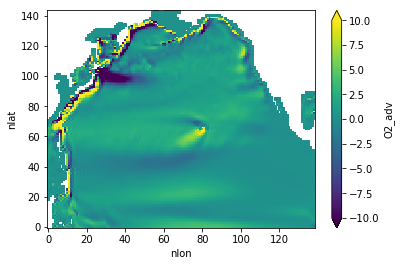

In [8]:
ds.O2_adv.mean('time',keep_attrs=True).plot(vmin=-10,vmax=10)

In [9]:
#levels = np.array([0.01,0.02,0.03,0.06,0.1,0.2,0.3,0.6,1.0,2.0,3.0,6.0,10.0])
#levels = np.concatenate((-1.*levels[::-1],np.array([0.]),levels))
levels = np.concatenate((np.arange(-10,0,1),np.arange(0,11,1)))
levels

array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
         3,   4,   5,   6,   7,   8,   9,  10])

/glade/work/mclong/miniconda3/envs/py3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


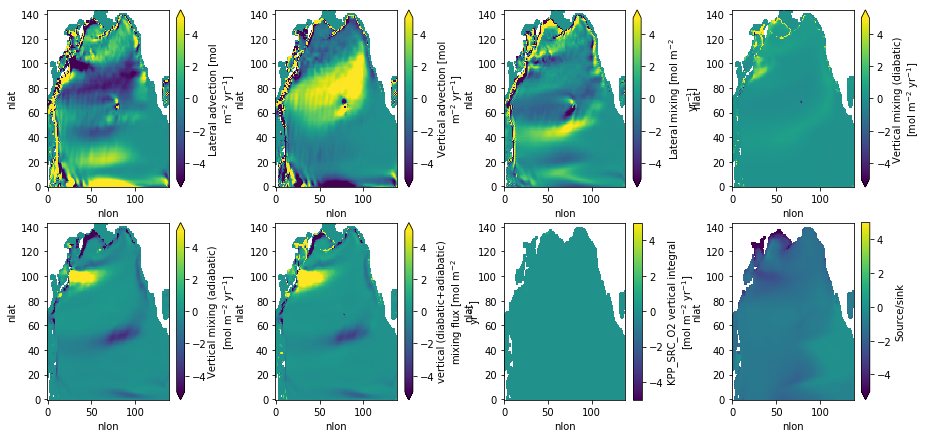

In [10]:
fig = plt.figure(figsize=(15,15))
for i,v in enumerate(['O2_lat_adv_res',
                      'O2_vert_adv_res',
                      'O2_lat_mix',
                      'O2_dia_vmix',
                      'O2_adi_vmix',
                      'O2_vmix',
                      'O2_kpp_src',
                      'O2_sms']):
    ax = fig.add_subplot(4,4,i+1)
    ds[v].mean('time',keep_attrs=True).plot(vmin=-5,vmax=5)
plt.subplots_adjust(wspace=0.5)

/glade/work/mclong/miniconda3/envs/py3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0,1,'mol m$^{-2}$ yr$^{-1}$')

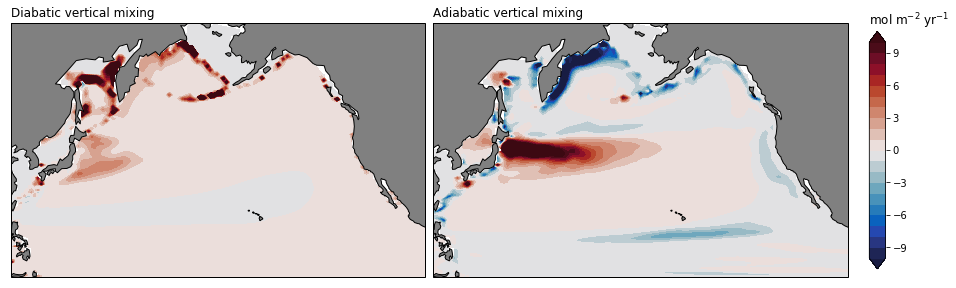

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

extent = [120,260,0,65]
prj = ccrs.Mercator(central_longitude=np.mean(extent[0:2]),
                    min_latitude=extent[2],
                    max_latitude=extent[3])

cf_specs = {'levels':levels,
            'cmap': cmocean.cm.balance, #'PiYG',
            'extend':'both'}


fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(1,2,1,projection=prj)
ax.set_extent(extent)
lon,lat,field = pt.adjust_pop_grid(ds.TLONG.values,ds.TLAT.values,ds.O2_dia_vmix.mean('time'))
cf = ax.contourf(lon,lat,field,**cf_specs,transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
              edgecolor='k',
              facecolor='gray'))
ax.set_title('Diabatic vertical mixing',loc='left')

ax = fig.add_subplot(1,2,2,projection=prj)
ax.set_extent(extent)
lon,lat,field = pt.adjust_pop_grid(ds.TLONG.values,ds.TLAT.values,ds.O2_adi_vmix.mean('time'))
cf = ax.contourf(lon,lat,field,**cf_specs,transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
              edgecolor='k',
              facecolor='gray'))
ax.set_title('Adiabatic vertical mixing',loc='left')


plt.subplots_adjust(wspace=0.02,right=0.9)
p = ax.get_position()
cbar_height = 0.22
cax = plt.axes((0.92,p.y0+p.height/2-cbar_height/2,0.015,cbar_height))
plt.colorbar(cf,cax=cax)    
cax.set_title(ds.O2_adi_vmix.attrs['units'],loc='left')


/glade/work/mclong/miniconda3/envs/py3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0,1,'mol m$^{-2}$ yr$^{-1}$')

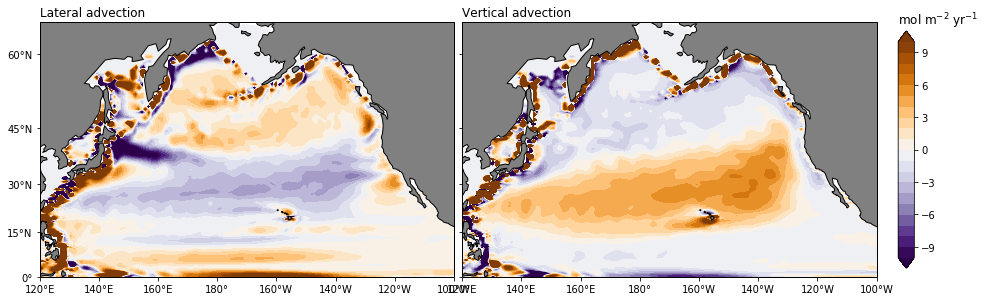

In [12]:
extent = [120,260,0,65]
prj = ccrs.Mercator(central_longitude=np.mean(extent[0:2]),
                    min_latitude=extent[2],
                    max_latitude=extent[3])

cf_specs = {'levels':levels,
            'cmap':'PuOr_r',
            'extend':'both'}


fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(1,2,1,projection=prj)
ax.set_extent(extent)
lon,lat,field = pt.adjust_pop_grid(ds.TLONG.values,ds.TLAT.values,ds.O2_lat_adv_res.mean('time'))
cf = ax.contourf(lon,lat,field,**cf_specs,transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
              edgecolor='k',
              facecolor='gray'))
ax.set_title('Lateral advection',loc='left')
ax.set_xticks(np.arange(extent[0],extent[1]+20,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(extent[2],extent[3],15), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)


ax = fig.add_subplot(1,2,2,projection=prj)
ax.set_extent(extent)
lon,lat,field = pt.adjust_pop_grid(ds.TLONG.values,ds.TLAT.values,ds.O2_vert_adv_res.mean('time'))
cf = ax.contourf(lon,lat,field,**cf_specs,transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
              edgecolor='k',
              facecolor='gray'))
ax.set_title('Vertical advection',loc='left')
ax.set_xticks(np.arange(extent[0],extent[1]+20,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(extent[2],extent[3],15), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_yticklabels([])


plt.subplots_adjust(wspace=0.02,right=0.9)
p = ax.get_position()
cbar_height = 0.22
cax = plt.axes((0.92,p.y0+p.height/2-cbar_height/2,0.015,cbar_height))
plt.colorbar(cf,cax=cax)    
cax.set_title(ds.O2_adi_vmix.attrs['units'],loc='left')

/glade/work/mclong/miniconda3/envs/py3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


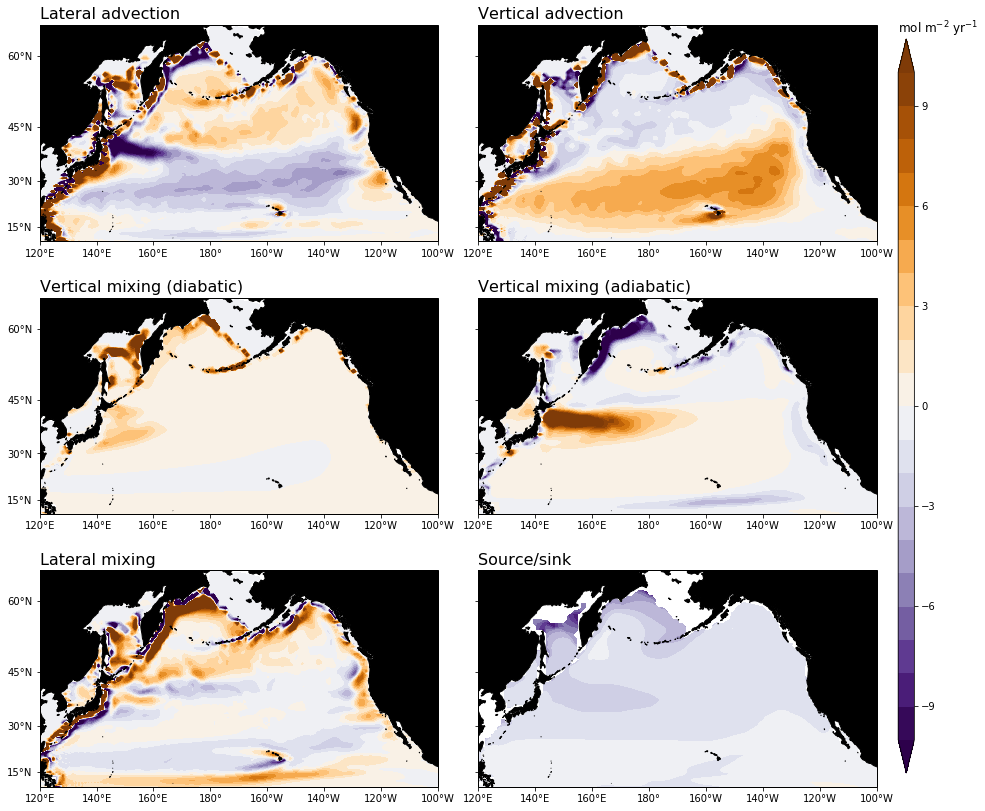

In [13]:
extent = [120,260,10,65]
prj = ccrs.Mercator(central_longitude=np.mean(extent[0:2]),
                    min_latitude=extent[2],
                    max_latitude=extent[3])

cf_specs = {'levels':levels,
            'cmap':'PuOr_r',
            'extend':'both'}

fig = plt.figure(figsize=(15,15))
variables = ['O2_lat_adv_res','O2_vert_adv_res',
             'O2_dia_vmix','O2_adi_vmix',
             'O2_lat_mix','O2_sms']

ax = []
for i,v in enumerate(variables):
    axi = fig.add_subplot(3,2,i+1,projection=prj)
    axi.set_extent(extent)
    lon,lat,field = pt.adjust_pop_grid(ds.TLONG.values,ds.TLAT.values,ds[v].mean('time'))

    cf = axi.contourf(lon,lat,field,**cf_specs,transform=ccrs.PlateCarree())
    land = axi.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','50m',
                  edgecolor='k',
                  facecolor='k'))
    
    axi.set_title(ds[v].long_name,loc='left',fontsize=16)
    axi.set_xticks(np.arange(extent[0],extent[1]+20,20), crs=ccrs.PlateCarree())
    axi.set_yticks(np.arange(extent[2]+5,extent[3],15), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axi.xaxis.set_major_formatter(lon_formatter)
    axi.yaxis.set_major_formatter(lat_formatter)
    
    if i%2 != 0:
        axi.set_yticklabels([])
    ax.append(axi)

plt.subplots_adjust(wspace=0.1,hspace=0.01,right=0.9)

ptop = ax[1].get_position()
pbot = ax[-1].get_position()

height = ptop.y0 + ptop.height - pbot.y0
cbar_height = 0.68
y0 = pbot.y0+height/2-cbar_height/2 

cax = plt.axes((0.92,y0,0.015,cbar_height))

plt.colorbar(cf,cax=cax)    
cax.set_title(ds.O2_adi_vmix.attrs['units'],loc='left')
plt.savefig(f'{dirf}/o2-budget-ann-mean.pdf',dpi=300,bbox_inches='tight')

/glade/work/mclong/miniconda3/envs/py3/lib/python3.6/site-packages/dask/array/reductions.py:380: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/glade/work/mclong/miniconda3/envs/py3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


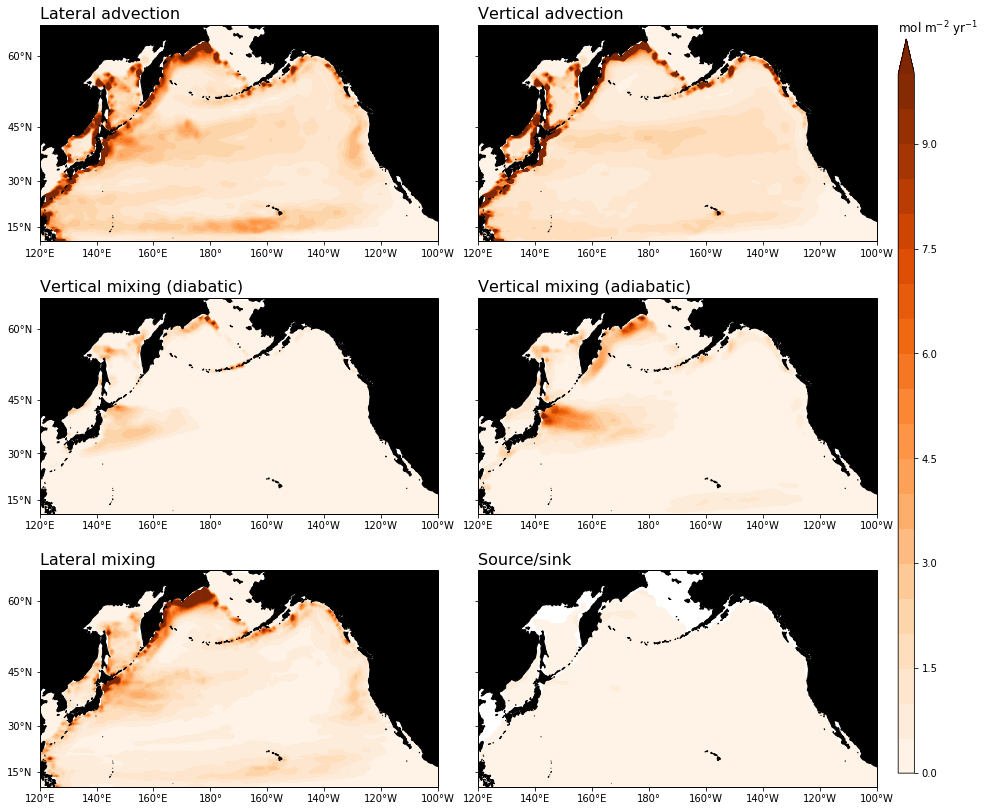

In [14]:
extent = [120,260,10,65]
prj = ccrs.Mercator(central_longitude=np.mean(extent[0:2]),
                    min_latitude=extent[2],
                    max_latitude=extent[3])

a = levels[levels>=0]
b = np.vstack((levels[levels>=0][:-1],levels[levels>=0][1:])).mean(axis=0)
cf_specs = {'levels':np.insert(a.astype(float),np.arange(0,len(a)-1,1)+1,b),
            'cmap':'Oranges',
            'extend':'max'}

fig = plt.figure(figsize=(15,15))
variables = ['O2_lat_adv_res','O2_vert_adv_res',
             'O2_dia_vmix','O2_adi_vmix',
             'O2_lat_mix','O2_sms']

ax = []
for i,v in enumerate(variables):
    axi = fig.add_subplot(3,2,i+1,projection=prj)
    axi.set_extent(extent)
    lon,lat,field = pt.adjust_pop_grid(ds.TLONG.values,ds.TLAT.values,ds[v].std('time'))

    cf = axi.contourf(lon,lat,field,**cf_specs,transform=ccrs.PlateCarree())
    land = axi.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','50m',
                  edgecolor='k',
                  facecolor='k'))
    
    axi.set_title(ds[v].long_name,loc='left',fontsize=16)
    axi.set_xticks(np.arange(extent[0],extent[1]+20,20), crs=ccrs.PlateCarree())
    axi.set_yticks(np.arange(extent[2]+5,extent[3],15), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axi.xaxis.set_major_formatter(lon_formatter)
    axi.yaxis.set_major_formatter(lat_formatter)
    
    if i%2 != 0:
        axi.set_yticklabels([])
    ax.append(axi)

plt.subplots_adjust(wspace=0.1,hspace=0.01,right=0.9)

ptop = ax[1].get_position()
pbot = ax[-1].get_position()

height = ptop.y0 + ptop.height - pbot.y0
cbar_height = 0.68
y0 = pbot.y0+height/2-cbar_height/2 

cax = plt.axes((0.92,y0,0.015,cbar_height))

plt.colorbar(cf,cax=cax)    
cax.set_title(ds.O2_adi_vmix.attrs['units'],loc='left')
plt.savefig(f'{dirf}/o2-budget-ann-std.pdf',dpi=300,bbox_inches='tight')

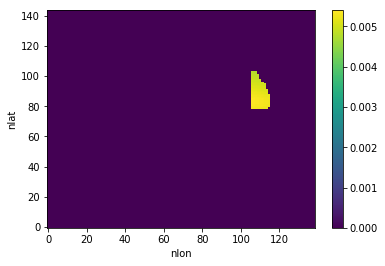

In [15]:
rmask = ds.TAREA.where((25 <= ds.TLAT) & (ds.TLAT <= 38) & (360-126<=ds.TLONG) & (ds.TLONG <= 360-115) & (ds.KMT > 0)).fillna(0.)
wgt = rmask / rmask.sum()
wgt.plot()

In [16]:
ccs = (ds * wgt).sum(['nlat','nlon'])
ccs

<xarray.Dataset>
Dimensions:          (nlat_G: 384, nlon_G: 320, nz_G: 60, time: 68)
Coordinates:
  * time             (time) object 1948-07-16 21:59:59 1949-07-16 21:59:59 ...
Dimensions without coordinates: nlat_G, nlon_G, nz_G
Data variables:
    TLAT             float64 dask.array<shape=(), chunksize=()>
    TLONG            float64 dask.array<shape=(), chunksize=()>
    ULAT             float64 dask.array<shape=(), chunksize=()>
    ULONG            float64 dask.array<shape=(), chunksize=()>
    KMT              float64 dask.array<shape=(), chunksize=()>
    KMU              float64 dask.array<shape=(), chunksize=()>
    DXU              float64 dask.array<shape=(), chunksize=()>
    DYU              float64 dask.array<shape=(), chunksize=()>
    REGION_MASK      float64 dask.array<shape=(), chunksize=()>
    TAREA            float64 dask.array<shape=(), chunksize=()>
    vol3d            (nz_G, nlat_G, nlon_G) float64 dask.array<shape=(60, 384, 320), chunksize=(60, 384, 320)>
   

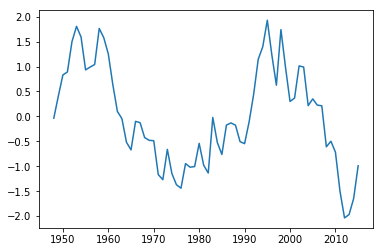

In [17]:
plt.plot([d.year for d in ccs.time.values],(ccs.O2_zint-ccs.O2_zint.mean())/ccs.O2_zint.std())
#plt.plot([d.year for d in ccs.time.values],(ccs.O2_adv-ccs.O2_adv.mean())/ccs.O2_adv.std())
#plt.plot([d.year for d in ccs.time.values],(ccs.O2_vmix-ccs.O2_vmix.mean())/ccs.O2_vmix.std())